## Load packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# load visualization packages
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
colors = sns.color_palette()

import scipy.stats as stats
from sklearn.linear_model import LinearRegression as ols
from sklearn.linear_model import Ridge as ridge
from sklearn.linear_model import Lasso as lasso

## Load data from qualtrics

In [2]:
df = pd.read_csv('qualtrics.csv')
df = df.rename(columns={'Q1 [0]': 'Control',
                       'Q1[1]': 'Treatment'})
df = df[(~df['Control'].isnull()) | (~df['Treatment'].isnull())]
df['Group'] = 'Control'
df.loc[df['Control'].isnull(), 'Group'] = 'Treatment'
df.columns = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Time', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Education', 'StudyArea',
       'Professional', 'Investment', 'In401k', 'DataScience', 'Control',
       'Treatment', 'CheckReference', 'Group']
df = df[['Time', 'Education', 'StudyArea','Professional', 'Investment', 'In401k', 'DataScience', 
         'Control','Treatment', 'CheckReference', 'Group']]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 1 to 152
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time            148 non-null    int64 
 1   Education       147 non-null    object
 2   StudyArea       147 non-null    object
 3   Professional    148 non-null    object
 4   Investment      148 non-null    object
 5   In401k          148 non-null    object
 6   DataScience     148 non-null    object
 7   Control         76 non-null     object
 8   Treatment       72 non-null     object
 9   CheckReference  148 non-null    object
 10  Group           148 non-null    object
dtypes: int64(1), object(10)
memory usage: 13.9+ KB


Undergraduate      78
< Undergraduate    45
Master's           16
> Master's          8
Name: Education, dtype: int64


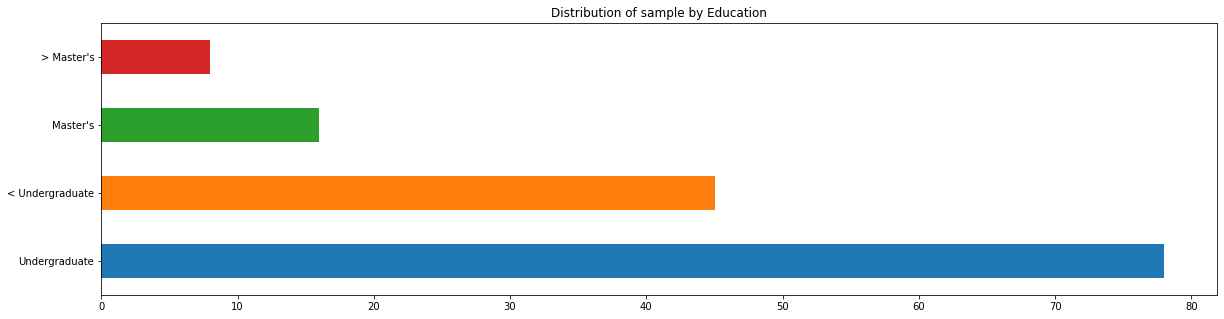

Others                                                       78
Business, Economics, and Finance                             34
Other STEM                                                   30
Statistics, Data Science                                      3
Business, Economics, and Finance,Statistics, Data Science     1
Business, Economics, and Finance,Other STEM                   1
Name: StudyArea, dtype: int64


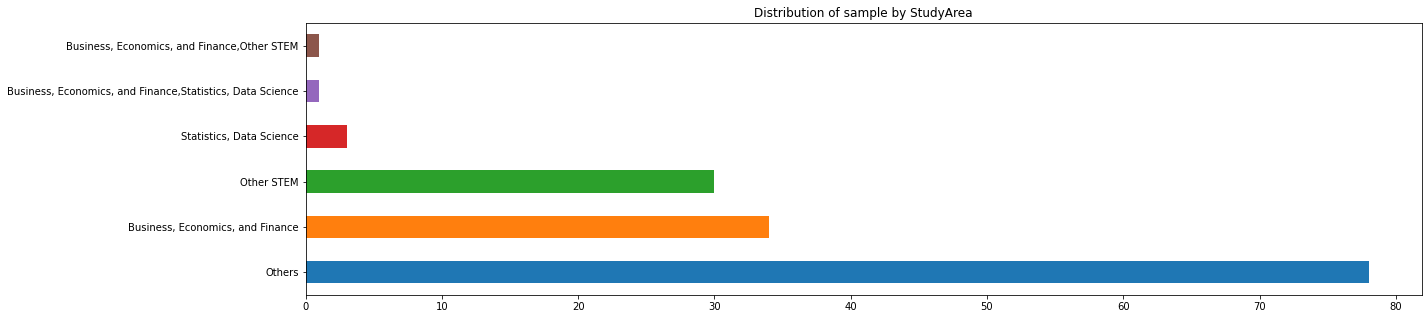

> 5 years work experience, including internships    132
1-3 years work experience, including internships      7
4-5 years work experience, including internships      5
No work experience                                    4
Name: Professional, dtype: int64


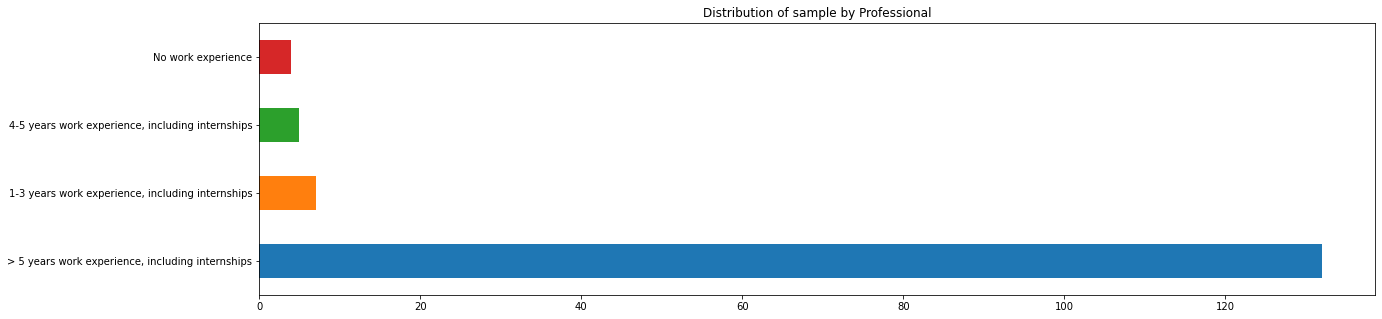

Yes, I am       84
No, I am not    64
Name: In401k, dtype: int64


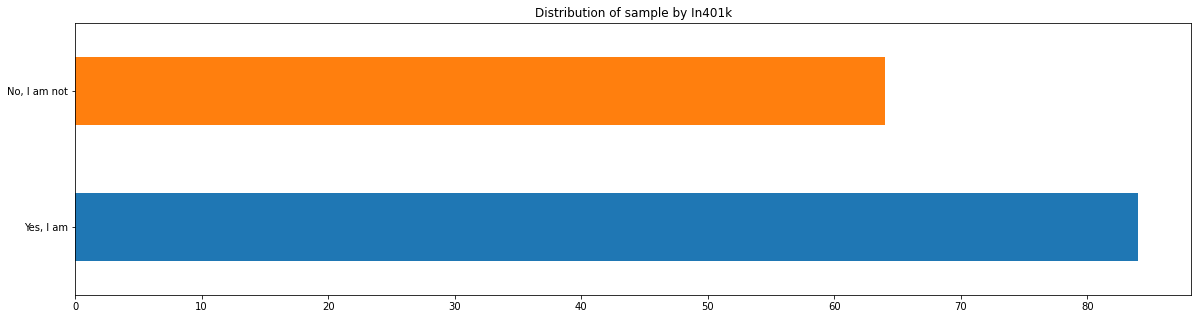

Yes, I primarily make investments myself.                                 83
Yes, but I primarily rely on professional investors to help me invest.    37
No, I don't have any                                                      28
Name: Investment, dtype: int64


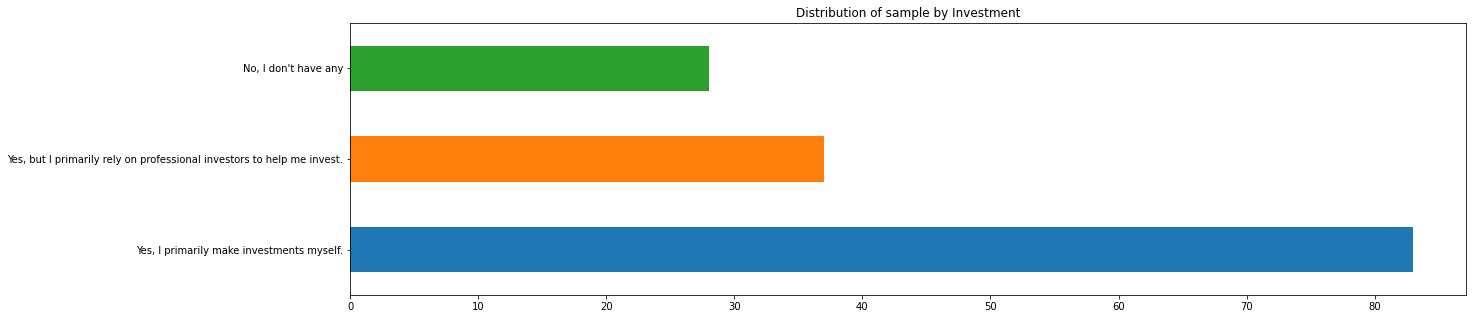

No     126
Yes     22
Name: DataScience, dtype: int64


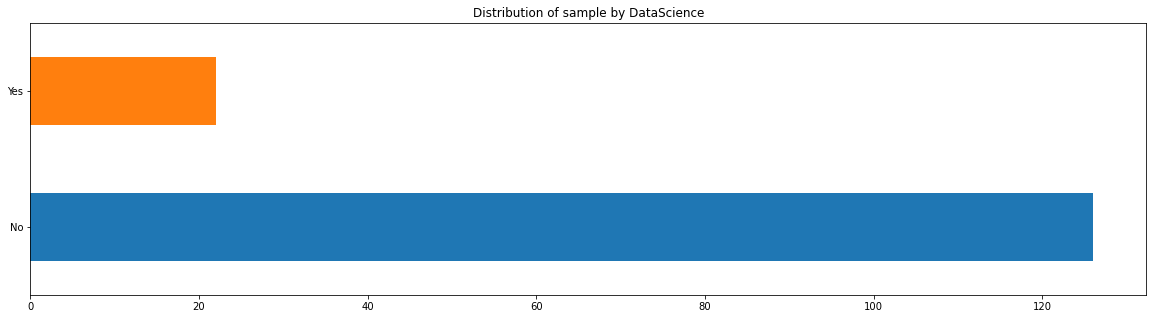

In [4]:
df.loc[df['In401k'] == "I am not sure", 'In401k'] = 'No, I am not'
df.loc[df['DataScience'] == "I am not sure", 'DataScience'] = 'No'

for i in ['Education', 'StudyArea', 'Professional',
         'In401k', 'Investment', 'DataScience']:
    df.loc[df[i].isnull(), i] = df[i].mode()
    print(df[str(i)].value_counts())
    df[str(i)].value_counts().plot(kind='barh', figsize=(20,5), color=colors)
    plt.title('Distribution of sample by ' + str(i))
    plt.show()
    plt.close()

In [5]:
cov = ['Education', 'Professional','In401k', 'Investment', 'DataScience', 'StudyArea']

Group      Education      
Control    Undergraduate      38
           < Undergraduate    29
           Master's            7
           > Master's          1
Treatment  Undergraduate      40
           < Undergraduate    16
           Master's            9
           > Master's          7
Name: Education, dtype: int64
Difference in education score: 0.3735380116959065
The variances are 0.4631232686980609 and 0.726658950617284 for the control and treatment groups, respectively.
The t-test of the mean education difference has a p-value of 0.0038915983156537215.


<AxesSubplot:ylabel='Education'>

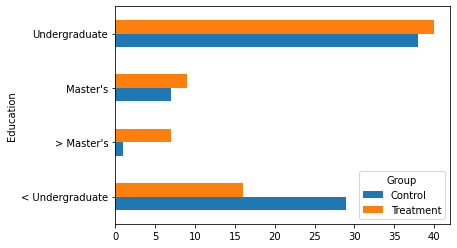

In [6]:
print(df.groupby('Group')[cov[0]].value_counts())
df['education_score'] = 0
df.loc[df['Education']=='Undergraduate','education_score'] = 1
df.loc[df['Education']=="Master's",'education_score'] = 2
df.loc[df['Education']=="> Master's",'education_score'] = 3
X1 = df[df['Group']=='Treatment']['education_score']
X0 = df[df['Group']=='Control']['education_score']
print("Difference in education score:", X1.mean() - X0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(X0), np.var(X1)))
print("The t-test of the mean education difference has a p-value of {}.".format(stats.ttest_ind(X1, X0, equal_var=True)[1]))

df.groupby('Group')['Education'].value_counts().unstack(0).plot.barh(color=colors)

Group      StudyArea                                                
Control    Others                                                       42
           Business, Economics, and Finance                             18
           Other STEM                                                   15
           Statistics, Data Science                                      1
Treatment  Others                                                       36
           Business, Economics, and Finance                             16
           Other STEM                                                   15
           Statistics, Data Science                                      2
           Business, Economics, and Finance,Other STEM                   1
           Business, Economics, and Finance,Statistics, Data Science     1
Name: StudyArea, dtype: int64
Difference in study area score: 0.041666666666666685
The variances are 0.1875 and 0.20659722222222227 for the control and treatment groups, respectivel

<AxesSubplot:ylabel='StudyArea'>

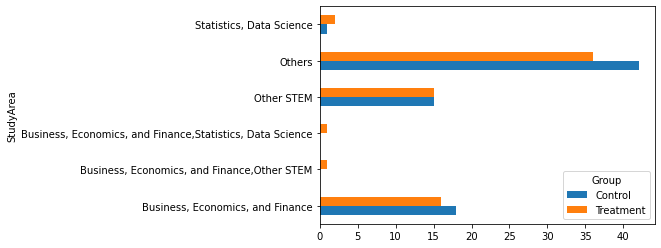

In [7]:
print(df.groupby('Group')[cov[-1]].value_counts())
df['study_area_relevance'] = 0
df.loc[df['StudyArea'].str.contains('Business', na=True),'study_area_relevance'] = 1
df.loc[df['StudyArea'].str.contains('Data', na=True),'study_area_relevance'] = 1
X1 = df[df['Group']=='Treatment']['study_area_relevance']
X0 = df[df['Group']=='Control']['study_area_relevance']
print("Difference in study area score:", X1.mean() - X0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(X0), np.var(X1)))
print("The t-test of the mean study area score difference has a p-value of {}.".format(stats.ttest_ind(X1, X0, equal_var=True)[1]))

df.groupby('Group')['StudyArea'].value_counts().unstack(0).plot.barh(color=colors)

Group      Professional                                    
Control    > 5 years work experience, including internships    68
           No work experience                                   4
           1-3 years work experience, including internships     3
           4-5 years work experience, including internships     1
Treatment  > 5 years work experience, including internships    64
           1-3 years work experience, including internships     4
           4-5 years work experience, including internships     4
Name: Professional, dtype: int64
Difference in experience score: 0.08333333333333348
The variances are 0.5822368421052632 and 0.2500000000000001 for the control and treatment groups, respectively.
The t-test of the mean experience score difference has a p-value of 0.4389979441937478.


<AxesSubplot:ylabel='Professional'>

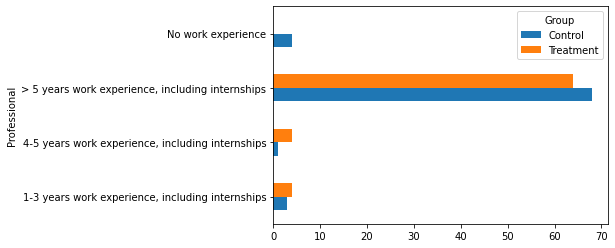

In [8]:
print(df.groupby('Group')[cov[1]].value_counts())
df['experience_score'] = 0
df.loc[df['Professional']=='1-3 years work experience, including internships','experience_score'] = 1
df.loc[df['Professional']=="4-5 years work experience, including internships",'experience_score'] = 2
df.loc[df['Professional']=="> 5 years work experience, including internships",'experience_score'] = 3
X1 = df[df['Group']=='Treatment']['experience_score']
X0 = df[df['Group']=='Control']['experience_score']
print("Difference in experience score:", X1.mean() - X0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(X0), np.var(X1)))
print("The t-test of the mean experience score difference has a p-value of {}.".format(stats.ttest_ind(X1, X0, equal_var=True)[1]))

df.groupby('Group')['Professional'].value_counts().unstack(0).plot.barh(color=colors)

Group      In401k      
Control    Yes, I am       39
           No, I am not    37
Treatment  Yes, I am       45
           No, I am not    27
Name: In401k, dtype: int64
Difference in e401k status: 0.11184210526315785
The variances are 0.24982686980609414 and 0.234375 for the control and treatment groups, respectively.
The t-test of the mean 401k status difference has a p-value of 0.1721153380799378.


<AxesSubplot:ylabel='In401k'>

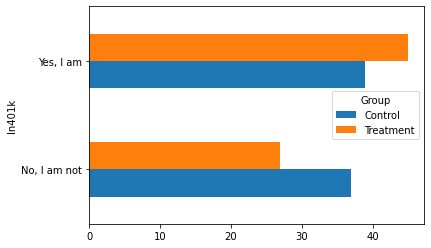

In [9]:
print(df.groupby('Group')[cov[2]].value_counts())
df['e401k_status'] = 0
df.loc[df['In401k']=="Yes, I am", 'e401k_status'] = 1
X1 = df[df['Group']=='Treatment']['e401k_status']
X0 = df[df['Group']=='Control']['e401k_status']
print("Difference in e401k status:", X1.mean() - X0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(X0), np.var(X1)))
print("The t-test of the mean 401k status difference has a p-value of {}.".format(stats.ttest_ind(X1, X0, equal_var=True)[1]))

df.groupby('Group')['In401k'].value_counts().unstack(0).plot.barh(color=colors)

Group      Investment                                                            
Control    Yes, I primarily make investments myself.                                 39
           No, I don't have any                                                      19
           Yes, but I primarily rely on professional investors to help me invest.    18
Treatment  Yes, I primarily make investments myself.                                 44
           Yes, but I primarily rely on professional investors to help me invest.    19
           No, I don't have any                                                       9
Name: Investment, dtype: int64
Difference in investment background: 0.11147660818713456
The variances are 0.17347645429362868 and 0.12495177469135793 for the control and treatment groups, respectively.
The t-test of the mean difference in investment background has a p-value of 0.08413212449532945.


<AxesSubplot:ylabel='Investment'>

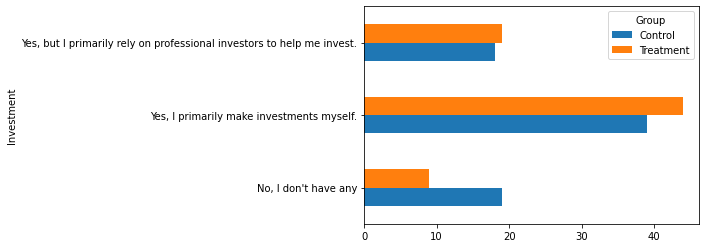

In [10]:
print(df.groupby('Group')[cov[3]].value_counts())
df['investment_background'] = 0
df.loc[df['Investment']=="Yes, but I primarily rely on professional investors to help me invest.", 'investment_background'] = 0.5
df.loc[df['Investment']=="Yes, I primarily make investments myself.", 'investment_background'] = 1
X1 = df[df['Group']=='Treatment']['investment_background']
X0 = df[df['Group']=='Control']['investment_background']
print("Difference in investment background:", X1.mean() - X0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(X0), np.var(X1)))
print("The t-test of the mean difference in investment background has a p-value of {}.".format(stats.ttest_ind(X1, X0, equal_var=True)[1]))

df.groupby('Group')['Investment'].value_counts().unstack(0).plot.barh(color=colors)

Group      DataScience
Control    No             66
           Yes            10
Treatment  No             60
           Yes            12
Name: DataScience, dtype: int64
Difference in Data science background: 0.03508771929824561
The variances are 0.11426592797783912 and 0.13888888888888895 for the control and treatment groups, respectively.
The t-test of the mean difference in Data science background has a p-value of 0.5518327819722867.


<AxesSubplot:ylabel='DataScience'>

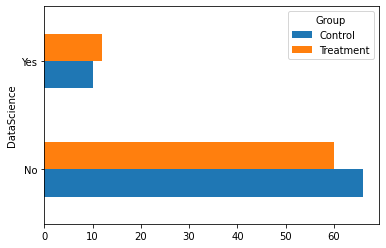

In [11]:
print(df.groupby('Group')[cov[4]].value_counts())
df['data_science_background'] = 0
df.loc[df['DataScience']=="Yes", 'data_science_background'] = 1
X1 = df[df['Group']=='Treatment']['data_science_background']
X0 = df[df['Group']=='Control']['data_science_background']
print("Difference in Data science background:", X1.mean() - X0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(X0), np.var(X1)))
print("The t-test of the mean difference in Data science background has a p-value of {}.".format(stats.ttest_ind(X1, X0, equal_var=True)[1]))

df.groupby('Group')['DataScience'].value_counts().unstack(0).plot.barh(color=colors)

## Outcome = Correct answer 8000-9000 USD (1 Correct, 0 Incorrect)


Control group answers:
Almost $6000    41
$19,559         20
$8000-$9000     15
Name: Control, dtype: int64

Treatment group answers:
Almost $6000    32
$8000-$9000     25
$19,559         15
Name: Treatment, dtype: int64
--------------------------------------------------
Distribution of outcome by group
--------------------------------------------------


<AxesSubplot:ylabel='Outcome'>

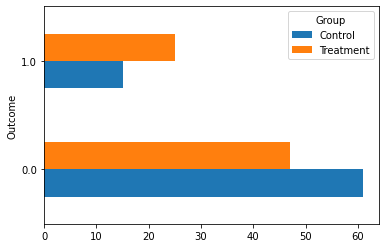

In [12]:
df['Outcome'] = None
df.loc[(df['Control']=='$8000-$9000') | (df['Treatment']=='$8000-$9000'), 'Outcome'] = 1
df.loc[(df['Control']=='Almost $6000') | (df['Treatment']=='Almost $6000'), 'Outcome'] = 0
df.loc[df['Outcome'].isnull(), 'Outcome'] = 0
df['Outcome'] = df['Outcome'].astype(float)

print('\nControl group answers:')
print(df['Control'].value_counts())
print('\nTreatment group answers:')
print(df['Treatment'].value_counts())

print("-" * 50)
print("Distribution of outcome by group")
print("-" * 50)
df.groupby('Group')['Outcome'].value_counts().unstack(0).plot.barh(color=colors)

In [13]:
print(df['Outcome'].mean())
print("-" * 50)
print("Mean outcoem by group")
print("-" * 50)
print(df.groupby('Group')['Outcome'].mean())

0.2702702702702703
--------------------------------------------------
Mean outcoem by group
--------------------------------------------------
Group
Control     0.1974
Treatment   0.3472
Name: Outcome, dtype: float64


In [26]:
Y1 = df[df['Group']=='Treatment']['Outcome']
Y0 = df[df['Group']=='Control']['Outcome']
print("ATE:", Y1.mean() - Y0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(Y0), np.var(Y1)))
print("The t-test of the mean outcome difference has a p-value of {}.".format(stats.ttest_ind(Y1, Y0, equal_var=True)[1]))

np.var(df['Outcome'])

ATE: 0.14985380116959063
The variances are 0.15841412742382258 and 0.22665895061728392 for the control and treatment groups, respectively.
The t-test of the mean outcome difference has a p-value of 0.04045422259059489.


0.1972242512783046

Alternative interpretation: Is it due to an easier random guess (1 of 2 from graph vs. 1 of 3 from text only)?

In [15]:
from statsmodels.stats.proportion import proportions_ztest

print("Is the answer just a random guess out of three possible numbers?\n")

# Random guess in the control group?
print("Control group:")
count_observed = int(df[df['Group']=='Control']['Outcome'].sum())
count_random = int(round((df[df['Group']=='Control'].shape[0])/3, 0))
n = int(df[df['Group']=='Control'].shape[0])
count = np.array([count_observed, count_random])
nobs = np.array([n, n])
stat, pval = proportions_ztest(count, nobs)
print(f"Out of {n} answers, there were {count_observed} correct answers vs. {count_random} if it were a random guess.")
print('P-value (H0: two numbers are the same): {0:0.3f}'.format(pval))

# Random guess in the treatment group?
print("\nTreatment group:")
count_observed = int(df[df['Group']=='Treatment']['Outcome'].sum())
count_random = int(round((df[df['Group']=='Treatment'].shape[0])/3, 0))
n = int(df[df['Group']=='Treatment'].shape[0])
count = np.array([count_observed, count_random])
nobs = np.array([n, n])
stat, pval = proportions_ztest(count, nobs)
print(f"Out of {n} answers, there were {count_observed} correct answers vs. {count_random} if it were a random guess.")
print('P-value (H0: two numbers are the same): {0:0.3f}'.format(pval))

print("\nIs the answer just a random guess out of two possible numbers?\n")

# Random guess in the control group?
print("Control group:")
count_observed = int(df[(df['Control']=='Almost $6000') | (df['Control']=='$8000-$9000')]['Outcome'].sum())
count_random = int(round((df[(df['Control']=='Almost $6000') | (df['Control']=='$8000-$9000')].shape[0])/3, 0))
n = int(df[(df['Control']=='Almost $6000') | (df['Control']=='$8000-$9000')].shape[0])
count = np.array([count_observed, count_random])
nobs = np.array([n, n])
stat, pval = proportions_ztest(count, nobs)
print(f"Out of {n} answers, there were {count_observed} correct answers vs. {count_random} if it were a random guess.")
print('P-value (H0: two numbers are the same): {0:0.3f}'.format(pval))

# Random guess in the control group?
print("\nTreatment group:")
count_observed = int(df[(df['Treatment']=='Almost $6000') | (df['Treatment']=='$8000-$9000')]['Outcome'].sum())
count_random = int(round((df[(df['Treatment']=='Almost $6000') | (df['Treatment']=='$8000-$9000')].shape[0])/3, 0))
n = int(df[(df['Treatment']=='Almost $6000') | (df['Treatment']=='$8000-$9000')].shape[0])
count = np.array([count_observed, count_random])
nobs = np.array([n, n])
stat, pval = proportions_ztest(count, nobs)
print(f"Out of {n} answers, there were {count_observed} correct answers vs. {count_random} if it were a random guess.")
print('P-value (H0: two numbers are the same): {0:0.3f}'.format(pval))

Is the answer just a random guess out of three possible numbers?

Control group:
Out of 76 answers, there were 15 correct answers vs. 25 if it were a random guess.
P-value (H0: two numbers are the same): 0.065

Treatment group:
Out of 72 answers, there were 25 correct answers vs. 24 if it were a random guess.
P-value (H0: two numbers are the same): 0.860

Is the answer just a random guess out of two possible numbers?

Control group:
Out of 56 answers, there were 15 correct answers vs. 19 if it were a random guess.
P-value (H0: two numbers are the same): 0.411

Treatment group:
Out of 57 answers, there were 25 correct answers vs. 19 if it were a random guess.
P-value (H0: two numbers are the same): 0.248


## Outcome = Efficiency (time taken to complete the survey in secs)

In [16]:
print(df['Time'].mean())

print(df.groupby('Group')['Time'].mean())

108.29054054054055
Group
Control     108.2632
Treatment   108.3194
Name: Time, dtype: float64


--------------------------------------------------
Histogram of Time (seconds)
--------------------------------------------------


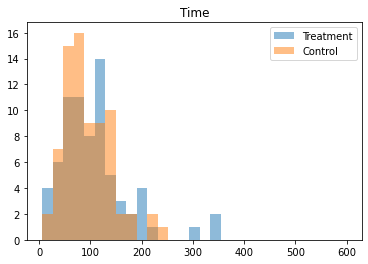

In [17]:
print("-" * 50)
print("Histogram of Time (seconds)")
print("-" * 50)
bins = np.linspace(df['Time'].min(), 600, 30)
pyplot.hist(df[df['Group']=='Treatment']['Time'], bins, alpha=0.5, label='Treatment')
pyplot.hist(df[df['Group']=='Control']['Time'], bins, alpha=0.5, label='Control')
pyplot.legend(loc='upper right')
pyplot.title('Time')
pyplot.show()
pyplot.close()

In [18]:
Y1 = df[df['Group']=='Treatment']['Time']
Y0 = df[df['Group']=='Control']['Time']

print("ATE:", Y1.mean() - Y0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(Y0), np.var(Y1)))
print("The t-test of the mean time difference has a p-value of {}.".format(stats.ttest_ind(Y1, Y0, equal_var=True)[1]))

ATE: 0.05628654970760749
The variances are 16627.7728531856 and 4579.161844135802 for the control and treatment groups, respectively.
The t-test of the mean time difference has a p-value of 0.9973905135252166.


## Outcome = Checking references for help to complete the survey

In [19]:
print(df['CheckReference'].value_counts())

print(df.groupby(['Group'])['CheckReference'].value_counts())

No     103
Yes     45
Name: CheckReference, dtype: int64
Group      CheckReference
Control    No                57
           Yes               19
Treatment  No                46
           Yes               26
Name: CheckReference, dtype: int64


--------------------------------------------------
Distribution of checking references by group
--------------------------------------------------


<AxesSubplot:ylabel='Reference'>

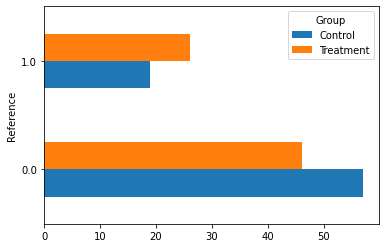

In [20]:
df['Reference'] = None
df.loc[(df['CheckReference']=='No'), 'Reference'] = 0
df.loc[df['Reference'].isnull(), 'Reference'] = 1
df['Reference'] = df['Reference'].astype(float)

print("-" * 50)
print("Distribution of checking references by group")
print("-" * 50)
df.groupby('Group')['Reference'].value_counts().unstack(0).plot.barh(color=colors)

In [21]:
Y1 = df[df['Group']=='Treatment']['Reference']
Y0 = df[df['Group']=='Control']['Reference']

print("ATE:", Y1.mean() - Y0.mean())
print("The variances are {} and {} for the control and treatment groups, respectively.".format(np.var(Y0), np.var(Y1)))
print("The t-test of the mean difference in checking references has a p-value of {}.".format(stats.ttest_ind(Y1, Y0, equal_var=True)[1]))

ATE: 0.1111111111111111
The variances are 0.1875 and 0.23070987654321 for the control and treatment groups, respectively.
The t-test of the mean difference in checking references has a p-value of 0.14384809634845286.


## Mean difference test

In [22]:
cols = ['education_score', 'study_area_relevance', 'experience_score',
       'e401k_status', 'investment_background', 'data_science_background',
       'Outcome', 'Time', 'Reference']

cols_name = ['Education score', 'Study area relevance', 'Work experience score',
       'Enrollment in 401(k)', 'Investment background', 'Causal analytics training',
       'Reading accuracy', 'Reading speed (secs)', 'Checking references']

mean1 = []
var1 = []
mean0 = []
var0 = []
diff = []
ttest_p = []

for i in cols:
    Y1 = df[df['Group']=='Treatment'][i]
    mean1.append(round(Y1.mean(), 4))
    var1.append(round(np.var(Y1), 4))
    Y0 = df[df['Group']=='Control'][i]
    mean0.append(round(Y0.mean(), 4))
    var0.append(round(np.var(Y0), 4))
    delta = Y1.mean() - Y0.mean()
    diff.append(round(delta, 4))
    p = round(stats.ttest_ind(Y1, Y0, equal_var=True)[1], 4)
    ttest_p.append(p)
    
report = pd.DataFrame({
    'Variable': cols_name,
    'Mean (treatment)': mean1,
    'Mean (control)': mean0,
    'Mean difference': diff,
    'P-value (t-test)': ttest_p
})

report[""] = ""
report.loc[report['P-value (t-test)']<0.01, ""] = "***"
report.loc[(report[""] == "") & (report['P-value (t-test)']<0.05), ""] = "**"
report.loc[(report[""] == "") & (report['P-value (t-test)']<0.1), ""] = "*"

display(report)

,Variable,Mean (treatment),Mean (control),Mean difference,P-value (t-test),
0,Education score,1.0972,0.7237,0.3735,0.0039,***
1,Study area relevance,0.2917,0.2500,0.0417,0.5714,
2,Work experience score,2.8333,2.7500,0.0833,0.4390,
3,Enrollment in 401(k),0.6250,0.5132,0.1118,0.1721,
4,Investment background,0.7431,0.6316,0.1115,0.0841,*
5,Causal analytics training,0.1667,0.1316,0.0351,0.5518,
6,Reading accuracy,0.3472,0.1974,0.1499,0.0405,**
7,Reading speed (secs),108.3194,108.2632,0.0563,0.9974,
8,Checking references,0.3611,0.2500,0.1111,0.1438,


# Block by professional and educational background

In [23]:
cols = ['education_score', 'study_area_relevance', 'experience_score',
       'e401k_status', 'investment_background', 'data_science_background']

Ys = ['Outcome', 'Time', 'Reference']

cols_name = ['Education score', 'Study area relevance', 'Work experience score',
       'Enrollment in 401(k)', 'Investment background', 'Causal analytics training']

Ys_name = ['Reading accuracy', 'Reading speed (secs)', 'Checking references']

df.loc[df['experience_score']<3, 'experience_score'] = 0
df.loc[df['experience_score']>0, 'experience_score'] = 1
df.loc[df['investment_background']<1, 'investment_background'] = 0
df.loc[df['investment_background']>0, 'investment_background'] = 1

mean1 = []
var1 = []
mean0 = []
var0 = []
diff = []
ttest_p = []
Yname = []
group = []
group_value = []
    
for cov in cols:
    
    df0 = df.loc[df[cov] == 0]
    for i in Ys:
        Y1 = df0[df0['Group']=='Treatment'][i]
        Y0 = df0[df0['Group']=='Control'][i]
        delta = Y1.mean() - Y0.mean()
        diff.append(round(delta, 4))
        p = round(stats.ttest_ind(Y1, Y0, equal_var=True)[1], 4)
        ttest_p.append(p)
        
        Yname.append(Ys_name[Ys.index(i)])
        group.append(cols_name[cols.index(cov)])
        group_value.append(f'Low (N={int(df0.shape[0])})')
        
    df1 = df.loc[df[cov] == 1]
    for i in Ys:
        Y1 = df1[df1['Group']=='Treatment'][i]
        Y0 = df1[df1['Group']=='Control'][i]
        delta = Y1.mean() - Y0.mean()
        diff.append(round(delta, 4))
        p = round(stats.ttest_ind(Y1, Y0, equal_var=True)[1], 4)
        ttest_p.append(p)
        
        Yname.append(Ys_name[Ys.index(i)])
        group.append(cols_name[cols.index(cov)])
        group_value.append(f'High (N={int(df1.shape[0])})')

report = pd.DataFrame({
    'Variable': Yname,
    'ATE': diff,
    'P-value (t-test)': ttest_p,
    'Covariate': group,
    'Covariate block': group_value
})

report[""] = ""
report.loc[report['P-value (t-test)']<0.01, ""] = "***"
report.loc[(report[""] == "") & (report['P-value (t-test)']<0.05), ""] = "**"
report.loc[(report[""] == "") & (report['P-value (t-test)']<0.1), ""] = "*"

report['P-value (t-test)'] = report['P-value (t-test)'].astype(str) + report['']

cols_order = ['Variable', 'ATE', 'P-value (t-test)', 'Covariate', 'Covariate block']
report = report[cols_order][report['Variable']=="Reading accuracy"]

In [24]:
report.pivot(index=['Covariate', 'Covariate block'], columns='Variable', values=['ATE', 'P-value (t-test)'])

ATE P-value (t-test)
Variable                                  Reading accuracy Reading accuracy
Covariate                 Covariate block                                  
Causal analytics training High (N=22)               0.2000            0.366
                          Low (N=126)               0.1348          0.0804*
Education score           High (N=78)               0.1408           0.1587
                          Low (N=46)                0.1417           0.3202
Enrollment in 401(k)      High (N=84)               0.1726          0.0862*
                          Low (N=64)                0.1071           0.3255
Investment background     High (N=83)               0.2098         0.0308**
                          Low (N=65)                0.0782           0.4932
Study area relevance      High (N=40)               0.1704           0.2512
                          Low (N=108)               0.1404          0.0983*
Work experience score     High (N=132)              0.1829         0.0172**
                          Low (N=16)               -0.1250           0.6186

## Regression analysis

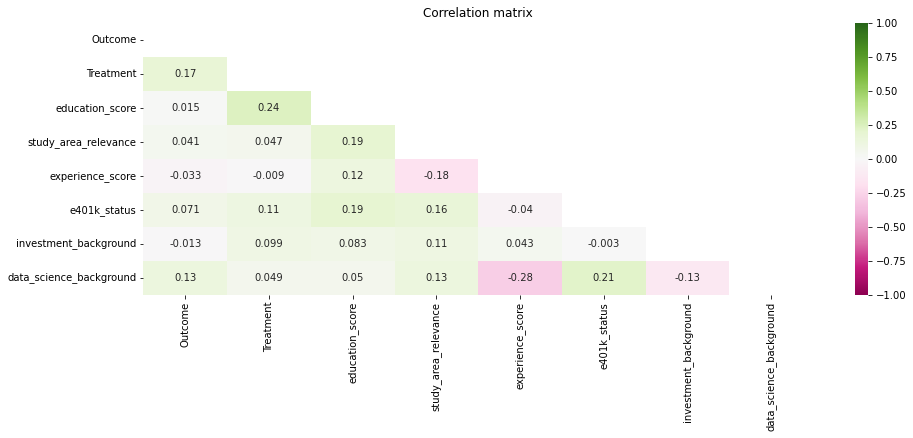

In [33]:
df['Treatment'] = 0
df.loc[df['Group']=='Treatment', 'Treatment'] =1

cols = ['Outcome', 'Treatment', 'education_score', 'study_area_relevance', 'experience_score',
       'e401k_status', 'investment_background', 'data_science_background']

plt.figure(figsize=(15,5))
ax = sns.heatmap(df[cols].corr().round(3), 
                 mask=np.triu(np.ones_like(df[cols].corr().round(2), dtype=bool)),
                 cmap="PiYG", vmax=1, vmin=-1, annot=True, annot_kws={"size":10})
plt.title('Correlation matrix')
plt.show()
plt.close()

In [25]:
import statsmodels.formula.api as smf

formula  = "Outcome ~ 1 + C(Group)"
mod = smf.logit(formula=formula, data=df)
res = mod.fit(cov_type='HC3')
display(res.summary())

formula  = "Outcome ~ 1 + C(Group) + education_score + study_area_relevance + experience_score + e401k_status + investment_background + data_science_background"
mod = smf.logit(formula=formula, data=df)
res = mod.fit(cov_type='HC3')
display(res.summary())

Optimization terminated successfully.
         Current function value: 0.569208
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  148
Model:                          Logit   Df Residuals:                      146
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                 0.02454
Time:                        17:16:21   Log-Likelihood:                -84.243
converged:                       True   LL-Null:                       -86.362
Covariance Type:                  HC3   LLR p-value:                   0.03952
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.4028      0.288     -4.868      0.000      -1.968      -0.838
C(Group)[T.Treatment]     0.7716      0.380      2.031      0.042       0.027       1.516
=========================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.560680
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  148
Model:                          Logit   Df Residuals:                      140
Method:                           MLE   Df Model:                            7
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                 0.03915
Time:                        17:16:21   Log-Likelihood:                -82.981
converged:                       True   LL-Null:                       -86.362
Covariance Type:                  HC3   LLR p-value:                    0.4540
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.5747      0.762     -2.066      0.039      -3.068      -0.081
C(Group)[T.Treatment]       0.7902      0.388      2.036      0.042       0.029       1.551
education_score            -0.1242      0.250     -0.496      0.620      -0.615       0.367
study_area_relevance        0.1217      0.434      0.280      0.779      -0.730       0.973
experience_score            0.0878      0.647      0.136      0.892      -1.180       1.356
e401k_status                0.1486      0.400      0.372      0.710      -0.635       0.932
investment_background      -0.0681      0.384     -0.177      0.859      -0.820       0.684
data_science_background     0.6807      0.521      1.306      0.191      -0.341       1.702
===========================================================================================
"""